In [1]:
using Statistics
#using CuArrays
using Random
using Zygote
using Flux, Flux.Optimise
using Metalhead, Images
using Metalhead: trainimgs
using Images.ImageCore
using Flux: onehotbatch, onecold
using Base.Iterators: partition


┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/kaitlinmaile/.julia/packages/CUDAdrv/b1mvw/src/CUDAdrv.jl:67


In [2]:
import Flux: Recur

function identities(n::Int64)
    fill(identity, n)
end

# reduce/merge modes in keras: 'sum', 'mul', 'concat', 'ave', None
# see https://github.com/keras-team/keras/blob/master/keras/layers/wrappers.py#L333

function concat(xs)
    # implicit concatenation
    return vcat(xs...)

    # explcit concatenation - preallocated size
    # n = length(xs)
    # m = length(xs[1])
    # concated = Array{eltype(xs[1].data)}(UndefInitializer(), n * m)
    # for i in 1:n
    #     concated[(i-1)*m+1:i*m] = xs[i].data
    # end
    # return param(concated)
end

function mul(xs)
    D = xs[1]
    for i in 2:length(xs)
        D = D .* xs[i]
    end
    D
end

# Parallel

mutable struct Parallel
    layers::Vector
    map::Vector{Function}
    inv::Vector{Function}
    reduce::Function
end

function Parallel(
    layers::Vector;
    map::Dict{Int64,Function} = Dict{Int64,Function}(),
    inv::Dict{Int64,Function} = Dict{Int64,Function}(),
    reduce::Function = concat)

    mappings::Vector{Function} = identities(length(layers))
    for (k,v) in map
        mappings[k] = v
    end

    inverses::Vector{Function} = identities(length(layers))
    for (k,v) in inv
        inverses[k] = v
    end

    return Parallel(layers, mappings, inverses, reduce)
end

function (p::Parallel)(xs)
    # NOTE: The implementation of the mapping is acutally sequential and not parallel.
    #       How to parallelize for cpu() and gpu() ia an open question to me, as `Base.pmap` does not exist anymore and 
    #       `Threads.@threads` does not seem to be a good idea neither.

    # double reverse; analog to `Flux.flip`, but without broadcast; see: recurrent.jl#flip(f, xs)
    # y = map^-1(f(map(x))) or map(x) |> f |> map^-1
    apply(l) = p.inv[l](p.layers[l](p.map[l](xs)))

    # implicit mapping
    Z = map(l -> apply(l), eachindex(p.layers))

    # explicit mapping - preallocated size
    # first = apply(1)
    # Z = Vector{typeof(first)}(UndefInitializer(), length(p.layers))
    # for l in eachindex(p.layers)
    #     if l == 1
    #         Z[l] = first
    #     else
    #         Z[l] = apply(l)
    #     end
    # end

    p.reduce(Z)
end

Flux.@treelike Parallel

# NOTE: Instead of generating `Flux.children` and `Flux.mapchildren` with `@treelike` macro, they are defined 
#       explicity, as `@treelike Parallel layers` is considerd not treelike: `error("@treelike T (a, b)")`
Base.getindex(c::Parallel, i::AbstractArray) = Parallel(c.layers[i]...)


function Base.show(io::IO, m::Parallel)
    print(io, "Parallel(\n")
    print(io, "  ", m.layers, ",\n")
    print(io, "     map = ", m.map, ",\n")
    print(io, "     inv = ", m.inv, ",\n")
    print(io, "  reduce = ", m.reduce, "\n")
    print(io, ")")
end



In [242]:
ReLUConvBN(C_in, C_out, kernel_size, stride, pad) = Chain(
    x -> relu.(x),
    Conv(kernel_size, C_in=>C_out),# ,pad=(pad,pad), stride=(stride,stride)),
    BatchNorm(C_out))

FactorizedReduce(C_in, C_out, stride) = Chain(
    x -> relu.(x),
    x -> cat(Conv((1,1), C_in=>C_out÷stride)(x),
            Conv((1,1), C_in=>C_out÷stride)(x[:,:,2:end,2:end]),
            dims=1), #or dims=2?
    BatchNorm(C_out))

SepConv(C_in, C_out, kernel_size, stride, pad) = Chain(
    x -> relu.(x),
    DepthwiseConv(kernel_size, C_in=>C_in, stride=(stride,stride), pad=(pad,pad)), 
    Conv((1,1), C_in=>C_in, stride=(1,1), pad=(0,0)),
    BatchNorm(C_in),
    x -> relu.(x),
    DepthwiseConv(kernel_size, C_in=>C_in, pad=(pad,pad), stride=(1,1)), 
    Conv((1,1), C_in=>C_out, stride=(1,1), pad=(0,0)),
    BatchNorm(C_out))

DilConv(C_in, C_out, kernel_size, stride, pad, dilation) = Chain(
    x -> relu.(x),
    DepthwiseConv(kernel_size, C_in=>C_in, pad=(pad,pad), stride=(stride,stride), dilation=dilation), 
    Conv(kernel_size, C_in->C_out),
    BatchNorm(C_out))

Identity(stride, pad) = x -> x[1:stride:end,1:stride:end,:,:]  |> f32
Zero(stride, pad) = x -> x[1:stride:end,1:stride:end,:,:]*0  |> f32

struct AdaptiveMeanPool{N}
  target_out::NTuple{N, Int}
end

AdaptiveMeanPool(target_out::NTuple{N, Integer}) where N = 
  AdaptiveMeanPool(target_out)

function (m::AdaptiveMeanPool)(x)
  w = size(x, 1) - m.target_out[1] + 1
  h = size(x, 2) - m.target_out[2] + 1
  return meanpool(x, (w, h); pad = (0, 0), stride = (1, 1))
end


In [243]:
PRIMITIVES = [
    #"none",
    "identity",
    "max_pool_3x3",
    #"avg_pool_3x3",
    #"skip_connect",
    #"sep_conv_3x3",
    #"sep_conv_5x5",
    #"dil_conv_3x3",
    #"dil_conv_5x5"
]



OPS = Dict(
  "none" => (C, stride, w) -> Chain(Zero(stride, 1),x->w.*x),
  "identity" => (C, stride, w) -> Chain(Identity(stride, 1),x->w.*x),
  "avg_pool_3x3" => (C, stride, w) -> Chain(MeanPool((3,3), stride=stride, pad=1), BatchNorm(C), x->w.*x)  |> f32,
  "max_pool_3x3" => (C, stride, w) -> Chain(MaxPool((3,3), stride=stride, pad=1), BatchNorm(C), x->w.*x),
  #"skip_connect" => (C, stride, w) -> Chain(stride == 1 ? Identity() : FactorizedReduce(C, C), x->w.*x),
  "skip_connect" => (C, stride, w) -> Chain(FactorizedReduce(C, C, stride), x->w.*x),
  "sep_conv_3x3" => (C, stride, w)-> SepConv(C, C, (3,3), stride, 1),
  #"sep_conv_5x5" => (C, stride, w)-> SepConv(C, C, 5, stride, 2),
  #"sep_conv_7x7" => (C, stride, w)-> SepConv(C, C, 7, stride, 3),
  "dil_conv_3x3" => (C, stride, w)-> DilConv(C, C, (3,3), stride, 2, 2),
  #"dil_conv_5x5" => (C, stride, w)-> DilConv(C, C, 5, stride, 4, 2),
  "conv_7x1_1x7" => (C, stride, w) -> Chain(
                                        x -> relu.(x),
                                        Conv((1,7), C->C, pad=(0,3), stride=(1,stride)), 
                                        Conv((7,1), C->C, pad=(3,0), stride=(stride,1)),
                                        BatchNorm(C_out),
                                        x->w.*x)
    )      


Dict{String,Function} with 8 entries:
  "sep_conv_3x3" => #1315
  "conv_7x1_1x7" => #1317
  "none"         => #1305
  "identity"     => #1307
  "avg_pool_3x3" => #1309
  "max_pool_3x3" => #1311
  "skip_connect" => #1313
  "dil_conv_3x3" => #1316

In [244]:
struct MixedOp
    ops
end


function MixedOp(C, stride, w)
    ops = Any[]
    for k in 1:length(PRIMITIVES)
        println(k)
        op = OPS[PRIMITIVES[k]](C, stride, w[k])
        append!(ops, op)
    end
    [println(op) for op in ops]
    MixedOp(ops)
end
(m::MixedOp)(x) = [println(op) for op in m.ops]#sum([op(x) for op in m.ops])
Flux.@functor MixedOp

mod = MixedOp(16,1,[2, 3])
println(mod)
print(params(mod))


1
2
#1301
#1308
MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1))
BatchNorm(16)
#1312
MixedOp(Any[var"#1301#1302"{Int64}(1), var"#1308#1325"{Int64}(2), MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), var"#1312#1329"{Int64}(3)])
Params([Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])

In [258]:
struct ChainOp3
    identity
    none
    maxpool
    sepconv
end

id(C, stride, w) = OPS["identity"](C, stride, w)
no(C, stride, w) = OPS["none"](C, stride, w)
ma(C, stride, w) = OPS["max_pool_3x3"](C, stride, w)
se(C, stride, w) = OPS["sep_conv_3x3"](C, stride, w)

ChainOp3(C::Int64, stride::Int64, w) = ChainOp3(id(C, stride, w[1]), 
                                              no(C, stride, w[2]), 
                                              ma(C, stride, w[3]), 
                                              se(C, stride, w[4]))

function (m::ChainOp3)(x)
    #m.identity(x) + m.none(x) + m.maxpool(x) + m.sepconv(x)
    #m.maxpool(x) + m.sepconv(x)
    m.sepconv(x)
end

Flux.@functor ChainOp3

mod = ChainOp3(16,1,[2,1,3,4])
println(mod)
print(params(mod))

ChainOp3(Chain(#1301, #1308), Chain(#1303, #1306), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), #1312), Chain(#1293, DepthwiseConv((3, 3), 16=>16), Conv((1, 1), 16=>16), BatchNorm(16), #1294, DepthwiseConv((3, 3), 16=>16), Conv((1, 1), 16=>16), BatchNorm(16)))
Params([Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.14686187 0.07551719 -0.037207823; -0.0612229 0.17000523 0.19695781; 0.18033619 -0.19449839 0.17429744]

Float32[0.037741058 0.13735025 0.07149296; -0.18668745 -0.09681761 0.023834435; 0.10187059 0.07628117 0.124996245]

Float32[-0.14555815 -0.07072475 0.15218362; -0.072569534 0.1414308 -0.12994705; 0.0011964479 -0.114757575 0.1066772]

Float32[-0.08709126 -0.053496484 0.15429287; -0.086010344 0.16953611 0.01669621; 0.089819945 0.063845634 0.06368704]

Float32[0.03171387 0.08528779 0.10678197; 0.17067198 -0.1

Float32[-0.15546073]

Float32[0.2820485]

Float32[0.41601586]

Float32[-0.31080624]

Float32[-0.03163169]

Float32[0.14646879]

Float32[0.21799794]

Float32[-0.07303106]

Float32[0.094048]

Float32[0.09901593]

Float32[0.16640894]

Float32[0.3384544]

Float32[-0.29649496]

Float32[-0.115551084]

Float32[-0.06296089]

Float32[-0.3343459]

Float32[-0.40672576]

Float32[0.18416427]

Float32[-0.38980284]

Float32[0.22186214]

Float32[0.054926787]

Float32[-0.37270865]

Float32[0.12402282]

Float32[-0.02438932]

Float32[-0.34401625]

Float32[0.36907846]

Float32[0.32374635]

Float32[0.3282365]

Float32[-0.3731479]

Float32[-0.34255058]

Float32[0.3475155]

Float32[0.2228299]

Float32[-0.3402333]

Float32[-0.15860392]

Float32[0.32150567]

Float32[0.16712521]

Float32[0.11065615]

Float32[-0.0006288243]

Float32[-0.30513248]

Float32[0.21916856]

Float32[-0.22559597]

Float32[0.25534055]

Float32[-0.3438589]

Float32[0.302997]

Float32[0.20847142]

Float32[0.054921936]

Float32[0.07298729]



In [259]:
function Cell(C_pp, C_p, C, red, red_p, weights, steps = 4, multiplier = 4) 
    if red_p
        p0 = FactorizedReduce(C_pp,C)
    else
        p0 = ReLUConvBN(C_pp,C,(1,1),1,0)
    end
    p1 = ReLUConvBN(C_p,C,(1,1),1,0)
    #mixops = MixedOp[]
    #model = x -> p1(p0(x))
    for i = 1:steps
       for j = 1:2+i
            #println(i,j)
            #red && j < 3 ? stride = 2 : stride = 1
            #println(stride)
            #print(mixop)
            #mixop = x -> weights[j,:]'*MixedOp(C, stride)(x)
            #model = Chain(model, x -> weights[j,:]'*mixop(x)) #add skip connections later
            #model = x -> weights[0,:]'*MixedOp(C, stride)(model(x))
            #append!(mixops, mixop)
        end
    end
    #model = Chain(p0, p1, mixops...)
    #states = [p0, p1]
    #offset = 0
    #for i = 1:steps
        #s = sum(weights[offset+j]'*mixops_[offset+j](states[j], weights[offset+j]) for j=1:length(states))
        #offset += length(states)
        #append!(states, s)
    #end
    #return cat(states[end-multiplier:end],dims=1)
    model = Chain(
        p0, 
        #p1, 
        ChainOp3(C, 2, softmax(weights[1,:])),
        ChainOp3(C, 1, softmax(weights[2,:])),
        ChainOp3(C, 2, softmax(weights[3,:])),
        ChainOp3(C, 1, softmax(weights[4,:])),
        ChainOp3(C, 2, softmax(weights[5,:])),
        x -> reshape(x, :, size(x,4)),
        Dense(256, 10, relu),
        softmax
    ) |> gpu
end

test_cell = Cell(3, 3, 16, false, false, rand(Float32, (5,4)))
print(test_cell)
print(params(test_cell))

Chain(Chain(#1287, Conv((1, 1), 3=>16), BatchNorm(16)), ChainOp3(Chain(#1301, #1308), Chain(#1303, #1306), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (2, 2)), BatchNorm(16), #1312), Chain(#1293, DepthwiseConv((3, 3), 16=>16), Conv((1, 1), 16=>16), BatchNorm(16), #1294, DepthwiseConv((3, 3), 16=>16), Conv((1, 1), 16=>16), BatchNorm(16))), ChainOp3(Chain(#1301, #1308), Chain(#1303, #1306), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), #1312), Chain(#1293, DepthwiseConv((3, 3), 16=>16), Conv((1, 1), 16=>16), BatchNorm(16), #1294, DepthwiseConv((3, 3), 16=>16), Conv((1, 1), 16=>16), BatchNorm(16))), ChainOp3(Chain(#1301, #1308), Chain(#1303, #1306), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (2, 2)), BatchNorm(16), #1312), Chain(#1293, DepthwiseConv((3, 3), 16=>16), Conv((1, 1), 16=>16), BatchNorm(16), #1294, DepthwiseConv((3, 3), 16=>16), Conv((1, 1), 16=>16), BatchNorm(16))), ChainOp3(Chain(#1301, #1308), Chain(#1303, #1306), Chain(MaxPool((3,

Float32[0.2774891]

Float32[0.12221853]

Float32[-0.344993]

Float32[0.037981153]

Float32[0.3143907]

Float32[-0.114354245]

Float32[0.14550845]

Float32[0.09681241]

Float32[-0.36318016]

Float32[0.0071662846]

Float32[0.049786553]

Float32[0.3791279]

Float32[-0.04123182]

Float32[-0.37188676]

Float32[-0.11158746]

Float32[0.36097023]

Float32[-0.24545932]

Float32[-0.14355302]

Float32[0.18456091]

Float32[0.17149043]

Float32[-0.14850444]

Float32[-0.25636756]

Float32[0.11361733]

Float32[0.3303801]

Float32[0.23448746]

Float32[0.14459501]

Float32[0.17331755]

Float32[-0.3152809]

Float32[0.33631045]

Float32[-0.33872342]

Float32[-0.35873246]

Float32[-0.15396057]

Float32[-0.16305886]

Float32[0.3024355]

Float32[-0.33491126]

Float32[0.35090894]

Float32[0.2385756]

Float32[0.36830646]

Float32[-0.34623247]

Float32[-0.2632028]

Float32[-0.2888714]

Float32[-0.28107476]

Float32[-0.34213638]

Float32[-0.035698246]

Float32[-0.29869753]

Float32[-0.015365365]

Float32[-0.157

Float32[-0.1254589 -0.19020452 0.10645001; 0.1969292 0.023644635 0.06142578; 0.09736237 0.07643971 -0.09026975]

Float32[-0.1364824 -0.17971 0.02105226; -0.13034204 0.06867491 -0.018088974; -0.17953172 -0.030514117 0.024581028]

Float32[-0.0099348 -0.15902393 0.14413525; 0.1587449 0.10016895 -0.13029034; -0.17996226 0.065696135 -0.18400449]

Float32[-0.1280787 0.03416503 0.16505824; 0.015364683 -0.003900861 0.06981219; 0.10230462 -0.10375716 -0.16536702], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.053473193]

Float32[0.28171587]

Float32[0.09350745]

Float32[-0.22123136]

Float32[0.24259537]

Float32[-0.41071084]

Float32[0.0059033707]

Float32[0.2747161]

Float32[0.04616671]

Float32[0.11724017]

Float32[-0.38619074]

Float32[0.09142327]

Float32[-0.076264486]

Float32[-0.17370912]

Float32[-0.013414058]

Float32[-0.15072168]

Float32[0.41802508]

Float32[0.40436202]

Float32[-0.018691083]

Float32[0.2885805]

Float32[-0.38853312

Float32[0.060993377]

Float32[0.008028427]

Float32[0.03644817]

Float32[-0.11725637]

Float32[-0.18104927]

Float32[-0.41411173]

Float32[0.26653644]

Float32[-0.40770808]

Float32[-0.27959228]

Float32[-0.014451913]

Float32[-0.010401359]

Float32[-0.30530912]

Float32[0.3302868]

Float32[-0.09148656]

Float32[0.29021433]

Float32[-0.36014444]

Float32[0.42451268]

Float32[0.06853731]

Float32[0.22792006]

Float32[0.08140699]

Float32[0.116854884]

Float32[0.049887415]

Float32[0.07846294]

Float32[0.41129652]

Float32[-0.101259604]

Float32[-0.1676793]

Float32[-0.29141873]

Float32[0.40288478]

Float32[-0.25972623]

Float32[-0.2553808]

Float32[0.25601265]

Float32[-0.3668892]

Float32[-0.28689182]

Float32[-0.28393292]

Float32[-0.009642764]

Float32[-0.061760332]

Float32[0.018049045]

Float32[-0.27406633]

Float32[-0.24913697]

Float32[-0.15740904]

Float32[-0.20569049]

Float32[0.13053592]

Float32[0.20366186]

Float32[-0.23284225]

Float32[0.13739455]

Float32[-0.11418235]

Fl

Float32[-0.31287122]

Float32[0.31359306]

Float32[-0.0038976576]

Float32[0.08800681]

Float32[-0.09563539]

Float32[0.16837646]

Float32[-0.08664034]

Float32[-0.2517897]

Float32[0.35134545]

Float32[0.10113624]

Float32[0.38751435]

Float32[-0.1754554]

Float32[0.28879666]

Float32[-0.39866418]

Float32[0.020950865]

Float32[-0.22979084]

Float32[0.0356745]

Float32[-0.12047927]

Float32[-0.29372114]

Float32[-0.4215482]

Float32[-0.074226975]

Float32[0.09109105]

Float32[-0.2705328]

Float32[0.20215303]

Float32[-0.18375194]

Float32[-0.04417545]

Float32[0.27990672]

Float32[0.15658851]

Float32[0.39904234]

Float32[-0.3967325]

Float32[0.091103956]

Float32[0.07614989]

Float32[0.13782527]

Float32[0.34253177]

Float32[-0.13223884]

Float32[0.048629563]

Float32[-0.22917916]

Float32[0.13935928]

Float32[0.15834872]

Float32[0.013248257]

Float32[0.15050994]

Float32[0.3669108]

Float32[-0.37064046]

Float32[0.25702426]

Float32[0.052735966]

Float32[-0.019030428]

Float32[-0.1

Float32[0.4219638]

Float32[-0.37245417]

Float32[-0.081536554]

Float32[0.41046825]

Float32[-0.31903568]

Float32[-0.00043019388]

Float32[0.17285319]

Float32[0.0077966573]

Float32[-0.015973335]

Float32[0.09693072]

Float32[-0.2909691]

Float32[-0.0754584]

Float32[0.41880473]

Float32[0.33278063]

Float32[0.29380992]

Float32[0.39143792]

Float32[-0.050708678]

Float32[-0.34316608]

Float32[-0.23969294]

Float32[0.08883013]

Float32[-0.07797948]

Float32[0.30701473]

Float32[0.14878576]

Float32[-0.42083946]

Float32[-0.11592667]

Float32[0.37655622]

Float32[-0.24833347]

Float32[0.39636403]

Float32[0.0037403225]

Float32[-0.21379851]

Float32[-0.02082605]

Float32[-0.17186426]

Float32[0.042711943]

Float32[0.3566744]

Float32[0.37402204]

Float32[-0.37081206]

Float32[0.25093704]

Float32[-0.37147173]

Float32[0.2301592]

Float32[-0.102014385]

Float32[0.38011247]

Float32[-0.41456845]

Float32[0.18698691]

Float32[-0.041395348]

Float32[0.20192136], Float32[0.0, 0.0, 0.0, 0.

Float32[0.3250714]

Float32[-0.120364465]

Float32[0.42136854]

Float32[0.00040479726]

Float32[0.29053098]

Float32[-0.09256199]

Float32[0.1885451]

Float32[0.28968742]

Float32[0.24674773]

Float32[0.043594632]

Float32[0.20833555]

Float32[0.27480716]

Float32[-0.21057789]

Float32[0.22734337]

Float32[-0.25083122]

Float32[-0.28060648]

Float32[0.2871555]

Float32[-0.21596083]

Float32[0.37867117]

Float32[-0.29598072]

Float32[-0.018229607]

Float32[-0.060665287]

Float32[0.007212432]

Float32[-0.21324722]

Float32[-0.3497018]

Float32[-0.076846235]

Float32[0.36618635]

Float32[-0.36212474]

Float32[-0.07129284]

Float32[-0.2385184]

Float32[0.17625271]

Float32[-0.20143542]

Float32[0.043715112]

Float32[0.1471038]

Float32[-0.23157965]

Float32[0.2517909]

Float32[-0.43251055]

Float32[-0.24084982]

Float32[0.35754314]

Float32[-0.13375984]

Float32[0.22531433]

Float32[0.35966736]

Float32[0.27123284]

Float32[-0.17129532]

Float32[-0.16355947]

Float32[-0.3441138]

Float32[-

Float32[-0.023294786], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[-0.064476766 -0.008546839 0.11338636 0.0058558276 -0.07528474 -0.1320665 -0.029010221 0.053961836 0.062850244 0.13574235 0.0078210905 0.03189631 0.030050145 0.04599282 -0.07115123 -0.0026952361 0.05056792 0.05814742 -0.046145614 -0.031693175 -0.05252724 -0.033896416 -0.08329587 -0.10943726 0.12690218 0.13253371 -0.13456963 -0.016702335 -0.086029485 -0.12279996 -0.008965393 -0.05906169 -0.095505066 0.10936274 -0.10056074 0.004480029 -0.068543576 -0.032778863 0.005949679 -0.11450632 0.11131268 0.13429175 0.037806746 -0.057779998 0.12517038 -0.1225738 0.10230789 -0.11834546 0.044457 0.11213195 -0.080679156 -0.041665837 -0.04831455 0.14989871 0.005690862 -0.08160216 -0.014592696 -0.041849565 -0.11

06844181 0.11227934 0.083641514 -0.013274619 0.13037448 0.13873251 0.08946601 0.05488578 -0.08541836 0.12310035 -0.00928562 -0.08172699; -0.054660976 0.1006436 0.05695205 -0.020946033 -0.110464394 0.07444907 -0.09272762 -0.09152269 -0.13913198 0.13629784 0.04750136 -0.13491865 0.011341763 -0.060439173 -0.008970227 -0.13289866 0.10212857 -0.14581753 0.008501363 0.08386431 0.10367969 -0.11333294 -0.12617923 0.0711982 0.017803991 0.020227663 0.05781351 0.041517593 0.09832656 0.049267355 -0.10009424 0.10170418 0.07963282 -0.00733955 0.0105951745 -0.09837447 0.089302726 -0.102548845 0.013776641 -0.04912015 0.094036564 -0.06615055 0.026665185 -0.1412827 0.12283183 0.084062934 0.07994947 0.01838719 -0.015564335 -0.14089869 -0.004960996 0.13153096 0.10807442 0.11773448 -0.10969747 -0.14635862 0.05694715 -0.036837183 -0.059699103 -0.12265906 -0.10585192 0.09430229 0.070026256 0.064555004 0.14457598 -0.11578981 0.12552457 -0.114399895 -0.00926145 0.1082126 0.055732053 0.05810878 0.037203174 -0.0

-0.11071906 -0.044887587 -0.14656115 0.046579387 0.08211783 -0.058435813 -0.068666466 0.0620252 -0.008055236 0.012284504 0.09361711 -0.011311613 0.090405494 0.114017434 -0.020073619 0.041199513 0.13716681 -0.11788587 0.022021478 -0.04805645 0.068887115 0.12781502 -0.033820827 -0.0051148613 0.09598177 -0.120956875 0.02992267 0.14845896 -0.049193233 -0.07330591 0.10010663 -0.14610943 0.10732296 -0.12905286 -0.097835384 0.13558985 -0.09819443 -0.056566942 -0.11963464 -0.035272285 -0.01268247 0.11960614 0.06742047 -0.07831467 0.11676646 -0.123456135 0.05236188 0.08301338 0.0874962 -0.0012862796 -0.1488716 0.059366807 -0.040437385 0.022785863 -0.006461047 0.035291445 0.03924954 -0.03654399; 0.0007161157 -0.14161126 -0.03047615 -0.11088155 -0.052156236 -0.024279432 -0.036725823 -0.086553104 0.06739705 -0.13782196 0.10529604 -0.04907328 -0.048841853 -0.13972609 0.1432139 0.044776477 -0.003995946 -0.06381196 0.13762054 0.030939283 0.0892459 0.12777664 0.028386919 -0.08547322 0.12389331 0.03824

051881306 0.036461458 -0.0811125 -0.0032560902 -0.09201333 0.05736674 -0.13468893 -0.05653407 0.13080567 0.08413709 0.011903655 0.049139522 0.119377725 -0.121681295 0.010711943 -0.0744741 0.06604127 0.07837483 -0.14107396 -0.018763097 -0.012348385 0.12055973 0.08524788 -0.10206834 -0.095142946 0.05751033 -0.06113889 0.018867262 0.04471367 -0.12649398 0.13653535 -0.12385174 0.14326836 0.12486291 -0.031005742 0.07205583 0.07908099 0.032656185 0.074018694 0.07952017 -0.14166565 0.017428871 -0.003588993 0.010465623 0.0124555575 0.016241957 -0.0027830363 0.05106819 -0.026725736 -0.07007037 0.10221078 0.065585904 0.14966975 0.03959247 -0.0872188 -0.02014176 -0.10676594 0.10293238 0.006474475 0.11050579 -0.05518452 -0.13068931 -0.05766323 0.020670602 0.024849597 -0.071945116 -0.04814776 -0.06340128 0.10070536 0.11564235 0.076672 -0.05984699 0.036692236 0.0026805191 0.105970114 -0.12470908 -0.051165514 -0.1381666 -0.012084376 -0.13235919 -0.021491097 0.13485691 -0.0584395 -0.1494422 0.03583582

In [260]:
epochs = 10
m = test_cell 

for epoch = 1:epochs
    for d in train
        gs = gradient(params(m)) do
            l = loss(d...)
        end
        update!(α_opt, params(m), gs)
    end
    @show accuracy(valX, valY)
end

accuracy(valX, valY) = 0.087
accuracy(valX, valY) = 0.087
accuracy(valX, valY) = 0.087
accuracy(valX, valY) = 0.087
accuracy(valX, valY) = 0.087
accuracy(valX, valY) = 0.087
accuracy(valX, valY) = 0.087
accuracy(valX, valY) = 0.087
accuracy(valX, valY) = 0.087
accuracy(valX, valY) = 0.087


In [241]:
struct DARTSConnection
    layers
    weights
end

DARTSConnection(C, stride, ws) = DARTSConnection([OPS[prim](C,stride,1) for prim in PRIMITIVES], ws)

function (skip::DARTSConnection)(input)
    print(size(layers(input)))
    wsum(layers(input), weights)
end

Flux.@functor DARTSConnection

dc = DARTSConnection(16, 1, [2,3,1])
println(dc)
print(params(dc))

DARTSConnection(Chain[Chain(#1231, #1238), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), #1242)], [2, 3, 1])
Params([Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [2, 3, 1]])

In [10]:
test = Dict("a"=>1, "b"=>3)
[test[x] for x in ["a","b"]]

2-element Array{Int64,1}:
 1
 3

In [11]:
function DARTSCell(C_pp, C_p, C, red, red_p, weights, steps = 4, multiplier = 4) 
    if red_p
        p0 = FactorizedReduce(C_pp,C)
    else
        p0 = ReLUConvBN(C_pp,C,(1,1),1,0)
    end
    p1 = ReLUConvBN(C_p,C,(1,1),1,0)
    model = Chain(
        p0, 
        #p1, 
        DARTSConnection(C, 1, weights[1,:]),
        DARTSConnection(C, 1, weights[2,:]),
        DARTSConnection(C, 1, weights[3,:]),
        DARTSConnection(C, 1, weights[4,:]),
    )
end
test_cell_ = DARTSCell(3, 3, 16, true, false, [1,2,3,4,5,6])
print(test_cell_)
print(params(test_cell_))

Chain(Chain(#9, Conv((1, 1), 3=>16), BatchNorm(16)), DARTSConnection(Chain[Chain(#27, #34), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), #38)], [1]), DARTSConnection(Chain[Chain(#27, #34), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), #38)], [2]), DARTSConnection(Chain[Chain(#27, #34), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), #38)], [3]), DARTSConnection(Chain[Chain(#27, #34), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), #38)], [4]))Params([Float32[0.4677588]

Float32[-0.35892898]

Float32[0.47022563]

Float32[-0.12343118]

Float32[-0.4799965]

Float32[0.38118127]

Float32[0.51487434]

Float32[0.096431464]

Float32[0.56075394]

Float32[-0.29599217]

Float32[0.26139742]

Float32[0.1575609]

Float32[0.4024681]

Float32[0.0008026722]

Float32[0.5331713]

Float32[0.5579775]

Float32[0.16963099]

Float32[-0.18813023]

Float32[-0.39844856]

Float32[-0.12247885]

Float32[

In [12]:
struct MixOp
    #weights #::
    ops
end

function MixOp(C, stride, w)
    Parallel([OPS["identity"](C, stride, w[1]),OPS["none"](C, stride, w[2])], reduce=sum)
end
#(m::MixOp)(x) = sum([op(x) for op in m.ops])
Flux.@functor MixOp

mod = MixOp(16,1,[2,1])
println(mod)
print(params(mod))


Parallel(
  Chain[Chain(#27, #34), Chain(#29, #32)],
     map = Function[identity, identity],
     inv = Function[identity, identity],
  reduce = sum
)
Params([])

In [14]:
function Network(α_normal, α_reduce, num_classes = 10, layers = 8, C = 16, steps = 4, mult = 4 , stem_mult = 3)
    C_c = C*stem_mult
    stem = Chain(
        Conv((3,3), 3=>C_c, pad=(1,1)),
        BatchNorm(C_c)) 
    C_pp = C_c
    C_p = C_c
    C_c = C
    red_p = false
    cells = []
    for i = 1:layers
        if i == layers//3 || i == 2*layers//3
            C_c = C_c*2
            red = true
            weights = α_reduce
        else
            red = false
            weights = α_normal
        end
        cell = Cell(C_pp, C_p, C, red, red_p, weights, steps, mult)
        red_p = red
        #model = cell(model)
        C_pp = C_p
        C_p = 4*C_c #4 is length of DARTS_V1 concat
        if i == 2*layers//3
            C_aux = C_p
        end
        push!(cells, cell)
    end

    s0 = stem
    s1 = stem
    for i = 1:layers
        st = s1
        s1 = Identity()
        s0 = s1
    end
    Chain(s0, cells...)
end
α_normal = 2e-3*(rand(k,num_ops) .- 0.5)
α_reduce = 2e-3*(rand(k,num_ops) .- 0.5)
m = Network(α_normal, α_reduce)
print(test_network)
print(params(test_network))

UndefVarError: UndefVarError: k not defined

In [51]:
steps = 4
k = floor(Int, steps^2/2+3*steps/2)
num_ops = length(PRIMITIVES)
α_normal = 2e-3*(rand(k,num_ops) .- 0.5)
α_reduce = 2e-3*(rand(k,num_ops) .- 0.5)

14×2 Array{Float64,2}:
 -0.000408567   0.000352386
 -0.000292472  -0.000258884
  0.000897387  -0.000535352
 -0.000331838  -0.00032332 
  0.000402008   9.39093e-5 
  0.000667207   0.000695044
  0.000321626  -0.00092783 
  0.000773594  -0.000552991
  0.000902712  -0.000505742
 -0.000565236  -0.000914481
 -0.000253571   0.000880467
 -0.000753054   0.000113571
 -0.000231456   0.000935511
  0.000804568   0.000488214

In [116]:
using Flux: crossentropy, Momentum

loss(x, y) = sum(crossentropy(m(x), y))

accuracy(x, y) = mean(onecold(m(x), 1:10) .== onecold(y, 1:10))

w_opt = Momentum(0.01, 0.9)
α_opt = ADAMW(3*10^-4, (0.9, 0.999), 10^-3)


Optimiser(Any[ADAM(0.00030000000000000003, (0.9, 0.999), IdDict{Any,Any}()), WeightDecay(0.0010000000000000002)])

In [147]:
Metalhead.download(CIFAR10)
X = trainimgs(CIFAR10)
labels = onehotbatch([X[i].ground_truth.class for i in 1:50000],1:10)

image(x) = x.img # handy for use later
ground_truth(x) = x.ground_truth
image.(X[rand(1:end, 10)])

getarray(X) = float.(permutedims(channelview(X), (2, 3, 1)))
imgs = [getarray(X[i].img) for i in 1:50000]

train = ([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:49000, 1000)]) #|> gpu
valset = 49001:50000
valX = cat(imgs[valset]..., dims = 4) #|> gpu
valY = labels[:, valset] #|> gpu

10×1000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  0  0  0  1  0  1  0  0  0  0  0  0  …  0  0  0  0  1  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  1  0  0  0  0  1  1
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  1  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0     0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0  …  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  1  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  1  0  0  0  0  0  0  0  0  1     0  0  0  0  0  0  0  0  0  1  0  0

,,,,,,,,,

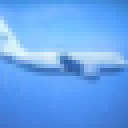
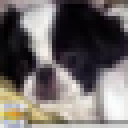
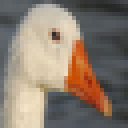
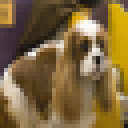
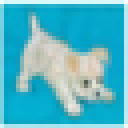
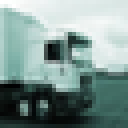
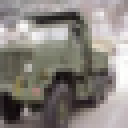
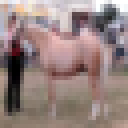
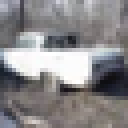
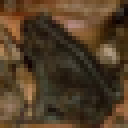

In [54]:
valset = valimgs(CIFAR10)
valimg = [getarray(valset[i].img) for i in 1:10000]
labels = onehotbatch([valset[i].ground_truth.class for i in 1:10000],1:10)
test = gpu.([(cat(valimg[i]..., dims = 4), labels[:,i]) for i in partition(1:10000, 1000)])
ids = rand(1:10000, 10)
image.(valset[ids])

In [19]:
rand_test = getarray.(image.(valset[ids]))
rand_test = cat(rand_test..., dims = 4) |> gpu
rand_truth = ground_truth.(valset[ids])
m(rand_test)


UndefVarError: UndefVarError: m not defined

In [20]:
accuracy(test[1]...)


UndefVarError: UndefVarError: m not defined

In [21]:
class_correct = zeros(10)
class_total = zeros(10)
for i in 1:10
  preds = m(test[i][1])
  lab = test[i][2]
  for j = 1:1000
    pred_class = findmax(preds[:, j])[2]
    actual_class = findmax(lab[:, j])[2]
    if pred_class == actual_class
      class_correct[pred_class] += 1
    end
    class_total[actual_class] += 1
  end
end

class_correct ./ class_total

UndefVarError: UndefVarError: m not defined

In [151]:
using Statistics
using CuArrays
using Zygote
using Flux, Flux.Optimise
using Metalhead, Images
using Metalhead: trainimgs
using Images.ImageCore
using Flux: onehotbatch, onecold
using Base.Iterators: partition


Metalhead.download(Metalhead.CIFAR10)
X = trainimgs(Metalhead.CIFAR10)
labels = onehotbatch([X[i].ground_truth.class for i in 1:50000],1:10)

image(x) = x.img 
ground_truth(x) = x.ground_truth
image.(X[rand(1:end, 10)])

getarray(X) = float.(permutedims(channelview(X), (2, 3, 1)))
imgs = [getarray(X[i].img) for i in 1:50000]

batch_size = 1


train = ([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:49000, batch_size)])
train_data = train |>
  x -> map(y->gpu.(y),x)
valset = 49001:50000
valX = cat(imgs[valset]..., dims = 4)
valY = labels[:, valset]


identity_layer(n) = Chain(
                              Conv((3,3), n=>n, pad = (1,1), stride = (1,1)),
                              BatchNorm(n,relu),
                              Conv((3,3), n=>n, pad = (1,1), stride = (1,1)),
                              BatchNorm(n,relu)
                              )

convolution_layer(n) = Chain(
                             Conv((3,3), n=> 2*n, pad = (1,1), stride = (2,2)),
                             BatchNorm(2*n,relu),
                             Conv((3,3), 2*n=>2*n, pad = (1,1), stride = (1,1)),
                             BatchNorm(2*n,relu)
                             )

simple_convolution(n) = Chain(
                              Conv((1,1), n=>n, pad = (1,1), stride = (2,2)),
                              BatchNorm(n,relu)
                              )


m_filter(n) = Chain(
  Conv((3,3), n=>2*n, pad = (1,1), stride = (2,2)),
  BatchNorm(2*n,relu),
) |> gpu

struct Combinator
    conv::Chain
end |> gpu
Combinator(n) = Combinator(m_filter(n))


function (op::Combinator)(x, y)
  z = op.conv(y)
  return x + z
end

n = 7

m = Chain(

  ConvTranspose((n, n), 3 => 3, stride = n),
  Conv((7,7), 3=>64, pad = (3,3), stride = (2,2)),
  BatchNorm(64,relu),
  MaxPool((3,3), pad = (1,1), stride = (2,2)),
  SkipConnection(identity_layer(64), (variable_1, variable_2) -> variable_1 + variable_2),
  SkipConnection(identity_layer(64), (variable_1, variable_2) -> variable_1 + variable_2),
  SkipConnection(convolution_layer(64), Combinator(64)),
  SkipConnection(identity_layer(128), (variable_1, variable_2) -> variable_1 + variable_2),
  SkipConnection(convolution_layer(128), Combinator(128)),
  SkipConnection(identity_layer(256), (variable_1, variable_2) -> variable_1 + variable_2),
  SkipConnection(convolution_layer(256), Combinator(256)),
  SkipConnection(identity_layer(512), (variable_1, variable_2) -> variable_1 + variable_2),
  MeanPool((7,7)),
  x -> reshape(x, :, size(x,4)),
  Dense(512, 10),
  softmax,
) #|> gpu

print(m)
print(params(m))

using Flux: crossentropy, Momentum, @epochs

loss(x, y) = sum(crossentropy(m(x), y))
opt = Momentum(0.01)


@epochs 1  train!(loss, params(m), train_data, opt)

Chain(ConvTranspose((7, 7), 3=>3), Conv((7, 7), 3=>64), BatchNorm(64, λ = relu), MaxPool((3, 3), pad = (1, 1), stride = (2, 2)), SkipConnection(Chain(Conv((3, 3), 64=>64), BatchNorm(64, λ = relu), Conv((3, 3), 64=>64), BatchNorm(64, λ = relu)), #511), SkipConnection(Chain(Conv((3, 3), 64=>64), BatchNorm(64, λ = relu), Conv((3, 3), 64=>64), BatchNorm(64, λ = relu)), #512), SkipConnection(Chain(Conv((3, 3), 64=>128), BatchNorm(128, λ = relu), Conv((3, 3), 128=>128), BatchNorm(128, λ = relu)), Combinator(Chain(Conv((3, 3), 64=>128), BatchNorm(128, λ = relu)))), SkipConnection(Chain(Conv((3, 3), 128=>128), BatchNorm(128, λ = relu), Conv((3, 3), 128=>128), BatchNorm(128, λ = relu)), #513), SkipConnection(Chain(Conv((3, 3), 128=>256), BatchNorm(256, λ = relu), Conv((3, 3), 256=>256), BatchNorm(256, λ = relu)), Combinator(Chain(Conv((3, 3), 128=>256), BatchNorm(256, λ = relu)))), SkipConnection(Chain(Conv((3, 3), 256=>256), BatchNorm(256, λ = relu), Conv((3, 3), 256=>256), BatchNorm(256, λ = 

Float32[-0.034351148 -0.01897763 -0.009528704 -0.041362528 -0.021722367 -0.007156901 0.023538362; -0.032329425 -0.02963603 0.03289829 0.029471654 -0.041036125 0.023272501 0.006325724; -0.030172572 -0.0103804795 0.023532368 -0.01617229 0.0145324515 0.008820356 0.03030221; -0.01857149 -0.035923276 0.025226066 -0.033591572 0.034366008 0.03571439 -0.036882605; -0.0112791825 0.038398035 0.037476957 0.032815587 -0.003073321 -0.032509435 -0.027830776; 0.0013957595 -0.040056463 -0.007079652 0.02306062 0.023580467 0.024452964 0.012576808; 0.009654795 -0.026653014 0.030928478 0.012287229 -0.03459291 0.019702388 0.034830876]

Float32[-0.02813024 0.032001633 -0.009840563 -0.01697545 -0.030753167 -0.015784018 0.042502273; -0.0424004 0.012584605 0.038148593 0.01593025 0.03862013 0.016478209 0.010120215; 0.0113043375 0.024568537 -0.01861541 -0.026562138 -0.020731013 0.02237657 0.029404711; -0.030508026 0.028481577 -0.01606315 -0.023470175 0.0012574373 0.02170143 -0.026550181; 0.012396839 -0.005117730

Float32[-0.041689504 0.013522723 0.040798478 -0.030144492 -0.011277256 0.037135713 -0.011313347; 0.016163087 -0.033076156 0.025077315 0.013232441 -0.012676257 -0.017053002 0.04259465; 0.0015987022 0.030341482 -0.023047248 0.037658263 -0.0031511711 -0.011065517 0.032860637; 0.020311695 0.030212965 -0.0155232735 -0.019543394 0.0025306526 0.03429148 0.04212196; -0.040668726 0.009780407 0.038458057 -0.029953301 0.011075465 -0.015865048 0.04096172; -0.03318537 -0.03868206 -0.036233626 -0.038070142 0.009418574 -0.0403232 0.015322431; -0.0074080643 -0.041417763 0.0063254386 0.026420942 -0.041190777 0.03613688 0.011597993]

Float32[0.007995233 0.021457942 -0.0393707 -0.009582143 -0.020978926 -0.030092642 0.022783425; -0.0334597 -0.010028584 -0.015756804 -0.042108763 0.022626093 0.031803604 -0.028230608; 0.03696347 0.013288948 0.036280442 -0.025713205 -0.029281687 0.011526309 0.008093275; 0.012136167 -0.031771 0.03627611 0.01586567 0.039302453 0.0415224 -0.02655912; 0.011291688 -0.039163906 0.0

Float32[-0.0056866854 -0.011935833 0.039460905 0.009730332 -0.013002528 -0.021585695 0.036863737; 0.018484294 0.016566403 -0.02886727 0.02186133 0.035548214 -0.014259965 0.023420995; 0.0015277013 0.03757124 0.008085406 0.028311932 -0.0074399873 0.040903978 0.014857714; 0.013422907 -0.02203543 -0.0119857155 -0.03816761 0.0020179804 0.013480546 -0.024095524; 0.032531593 0.009433556 -0.035371833 0.028289346 -0.02017066 0.027142936 0.03184354; 0.032047756 0.032807954 -0.016173871 -0.02432993 0.016989239 -0.03040067 -0.020014258; -0.012199432 -0.033092253 -0.0019283171 -0.030742556 0.01994708 -0.02612173 0.02970383]

Float32[0.0056031886 -0.029374612 -0.024918405 0.034853574 0.0008204037 -0.020097705 -0.03810042; 0.034553938 -0.022270039 -0.017479029 0.027453186 0.033287235 -0.04218539 -0.037380233; -0.007932397 0.028264396 0.007376794 0.031901076 -0.0044335495 -0.039710805 -0.040857013; -0.023949793 -0.0012799626 -0.0013505253 0.038888324 -0.026373198 -0.029731145 0.03955163; 0.020298772 0

Float32[0.030455312 -0.006066682 -0.04211911 -0.017684214 -0.024124542 0.025012828 0.003404169; 0.03949499 0.001755218 -0.027151141 0.023929121 0.006927784 0.015381486 0.031860773; 0.017818367 -0.03970843 0.0066963537 0.04136144 -0.009139901 -0.02104952 0.022475723; 0.033965044 0.02260151 0.031862568 -0.016121818 0.01891879 -0.0151164 0.03337535; 0.03731493 0.0018263718 -0.028763765 -0.016962994 -0.038055025 0.036691464 -0.030213872; 0.010052414 -0.037361283 0.03865048 0.0081607085 0.025644885 0.0047484566 0.020789387; -0.011412296 0.031398047 -0.00848594 -0.008324176 -0.015577355 0.037125584 0.006577815]

Float32[0.0015656683 -0.028014475 -0.003976233 0.03804575 -0.019985383 0.0068351245 0.01737475; 0.03373498 0.000229066 0.0077255093 -0.023107598 -0.023017209 0.03214267 0.003027628; 0.015459357 0.0130190505 0.037996173 -0.0033689032 -0.020992156 -0.03325987 -0.008483943; -0.011095462 -0.005076675 0.010550929 0.017105963 -0.008756225 0.026799327 0.0055607166; -0.03654568 -0.035110366 

Float32[0.0029353248 0.018361393 0.029828748 -0.028809143 -0.03837295 0.0051089344 -0.040811606; 0.014733498 0.041333176 -0.04091666 -0.0038869467 0.014744822 0.020161131 0.028678047; 0.03417865 0.014954889 -0.0037413163 0.01212098 -0.006487856 0.019229487 0.0025685583; -0.012330323 0.014281349 0.0011591918 -0.03729065 -0.021055808 -0.013886421 -0.013081561; 0.042072978 -0.03404784 -0.016424432 -0.009085259 0.032693163 0.040249806 -0.03060191; 0.0344545 -0.023267303 -0.039115403 0.000991087 -0.027784033 0.036840092 0.01813467; 0.042702608 0.008541072 0.0011517615 0.038974002 -0.037252203 -0.023610005 -0.022726214]

Float32[0.022903502 -0.02598032 0.020798977 0.034171972 0.012512871 0.008798066 -0.017203066; 0.012233423 0.019748203 0.016173024 -0.025135148 -0.032371234 -0.03938132 -0.0040997965; 0.013254487 -0.035124034 0.014874511 0.01750396 0.0055356636 -0.035644155 -0.02335455; -0.0035356218 0.0022172946 0.0012537577 -0.016907107 -0.01307147 0.015876392 -0.013633484; 0.03458873 -0.01

Float32[0.013199967 -0.017393759 0.011358775 0.0022771857 0.01252289 0.0042539476 0.027132284; 0.021998145 -0.032511942 -0.017305676 0.024132075 0.0064210035 0.0132028 0.0005834894; -0.0007329317 0.0069583617 0.001939172 0.038558953 -0.03817216 0.0012997666 0.034319866; -0.037853226 0.032615345 -0.017029235 0.018329144 0.033251755 0.005730666 -0.012792268; -0.018647587 0.041794 0.00028107828 -0.022452515 -0.030374058 -0.014242017 0.040966593; 0.012392457 -0.04140052 -0.029423261 0.024413195 -0.030911976 0.028595906 -0.039668508; -0.010640133 0.008502717 -0.0114607 -0.013102547 -0.036257192 0.039102957 0.018231051]

Float32[0.016011504 -0.013182232 -0.033260856 -0.010584696 -0.013362486 0.010928306 -0.0047180625; 0.015590249 -0.03167944 -0.04268108 -0.018188171 0.010091828 0.029007642 0.004699502; 0.0029255808 -0.0076642833 -0.009662857 -0.033342253 0.0065285647 0.010066419 0.015702438; 0.0019605968 -0.011680155 -0.010222965 -0.035933845 0.0044330196 -0.034927256 0.03180436; -0.00933999

Float32[-0.011973994 -0.018825294 0.004484675 -0.037021376 -0.036617763 0.01766965 0.04016691; 0.029204184 0.01378522 0.027360883 -0.030760413 -0.03487812 0.013047049 -0.039962836; -0.03623432 0.016963188 0.006506457 -0.029997006 -0.025350781 0.017389508 -0.006136103; -0.04056258 -0.0027075838 0.0064683473 0.03972119 -0.03406048 0.019881826 0.034945928; 0.001888383 -0.00555985 -0.02562444 0.036418956 -0.00645683 -0.021805007 -0.020970201; -0.013037794 -0.012968832 0.02177982 0.04230412 -0.03153337 0.015040517 -0.010973142; -0.01106408 0.041914217 -0.027198005 0.023355743 0.0027393743 0.019415276 0.009845395]

Float32[0.021962011 -0.026940217 0.039325997 0.03219265 0.0008484636 0.008181807 0.00987955; 0.014667451 -0.035036806 -0.02472595 0.010137654 -0.010597131 0.014284947 0.020923449; -0.03277093 -0.036329214 -0.032962043 -0.031621374 -0.027040817 -0.028555606 0.016823214; 0.04236652 0.010637657 -0.03433754 -0.0127960285 -0.039623447 0.021624345 -0.013696718; 0.030241992 0.026620673 0

Float32[0.03844928 0.031648852 0.03278352 0.0076044635 -0.021165377 -0.018259998 0.013183618; 0.010584391 -0.042088274 0.0032470927 0.020296203 -0.006161513 0.03283276 0.0325562; -0.029907903 -0.038674455 -0.033872508 0.011450212 -0.017604968 -0.01397107 -0.03695499; 0.011235416 -0.039696425 0.013317599 0.034480184 -0.042306047 0.010176936 -0.020657139; -0.005845566 -0.016726313 -0.0035694812 -0.0026114483 -0.025465833 0.030796781 -0.01971571; -0.008226797 0.009413773 0.007903613 -0.010223067 -0.009159226 -0.020071141 0.004483075; 0.021747388 -0.024766568 -0.005650431 -0.01926406 0.0039566937 0.030823046 -0.0046154344]

Float32[0.042319473 0.009616481 0.009836598 0.020809067 -0.0055718874 -0.021976994 -0.0167854; -0.0086547285 -0.014493119 -0.024494337 -0.027310286 0.03088046 -0.0031522925 -0.0003729228; 0.0082589025 -0.02695628 0.0004200325 -0.0105288625 -0.00096034654 0.018012514 0.014053089; -0.033303868 0.011502958 0.012140091 -0.017774498 -0.024409045 0.017084876 -0.040084757; -0.

Float32[-0.009992055 -0.04256668 -0.0014986935 0.020970445 0.027988505 0.039408967 0.042462613; 0.010685501 -0.010526732 0.0033513415 0.0065374323 0.021290816 -0.041740537 -0.029674526; -0.01746738 0.031067504 0.015914654 0.03759981 -0.031168705 -0.015854152 0.040509775; -0.039675266 -0.032745514 -0.004574583 -0.038698662 0.0072732586 -0.026815064 -0.032792084; 0.0045211436 0.012062974 -0.030771004 -0.036923517 -0.012198035 0.0028208836 0.0067900326; -0.022419838 -0.02201968 -0.0331728 -0.01219617 0.027210258 -0.034678806 0.01834802; -0.009190863 0.023318622 0.0010726168 -0.009119251 0.0012444011 -0.017729245 -0.031721577]

Float32[0.0021754135 0.029765168 0.037639458 0.03477346 0.032656603 0.009841491 0.024564715; 0.028793609 -0.012233913 0.042137872 0.028349044 0.0045269635 0.014117943 0.0034837623; 0.01834326 0.010038939 -0.015533812 0.0038441485 -0.038073983 0.006512695 -0.008098351; 0.018518327 -0.01022058 -0.036770802 0.00932041 -0.040289015 0.019678263 -0.0014554467; -0.03800351

Float32[0.019637145 0.0013057089 -0.022054834 0.008870738 0.035030954 -0.018528948 0.028854325; -0.008457004 -0.03938597 0.03523194 -0.024372801 0.002847741 -0.031691264 0.006800704; 0.0013858728 -0.0334363 -0.03722293 0.014350343 0.04255678 0.012323362 -0.040251363; 0.010086008 -0.008545811 -0.012133833 -0.005959732 -0.012064473 -0.023510404 -0.0048520532; 0.041394226 0.002537461 0.03194945 -0.033220574 0.020606676 -0.015435536 0.0026261867; -0.009093504 -0.013476306 0.00041815708 0.020814277 0.02903875 -0.024250276 -0.019733943; 0.025465854 0.021303628 0.042103603 0.0031893216 -0.017696965 0.040176217 -0.012663119]

Float32[-0.037047345 0.0047083492 0.021176182 0.0053051296 -0.0062892553 0.03958183 -0.0125831785; 0.01701574 0.03704818 -0.042544745 0.039123423 0.0043558315 -0.006155693 -0.00023397879; -0.026538327 0.019850546 0.034761965 -0.0016744833 0.037644953 -0.036050744 0.025000464; 0.024215193 -0.023500945 0.005133539 -0.03616281 0.0065516913 -8.6605585e-5 0.015323551; -0.00161

Float32[-0.009444218 0.023657644 0.00068925694 -0.010757286 0.029819045 -0.02069319 -0.0054139853; -0.035385553 0.015876066 -0.037880957 0.024843328 -0.042400096 0.008599129 -0.012833608; -0.016369658 -0.0025267384 0.025123477 0.0071677254 0.011526075 0.0048692888 0.018472308; 0.004204015 0.033138547 0.03842542 0.01052978 0.02423241 -0.022108162 0.024680706; 0.008962643 -0.024812402 -0.020322163 -0.028974129 -0.004528635 0.040388707 -0.017453386; 0.017466197 0.012013072 0.030042129 -0.039055306 0.012307411 -0.03208923 -0.020084055; -0.040385254 0.02781294 -0.03130186 -0.03283525 0.00072992494 -0.03575456 0.010818267], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

Float32[-0.051801212 0.01945267 -0.033475474; -0.049270894 -0.032319877 -0.005127862; 0.021276616 -0.014390227 -0.062119484]

Float32[0.042639367 -0.016050557 -0.066803455; 0.0037036387 0.055181097 -0.069862545; -0.02697831 0.023515802 -0.0115913]

Float32[-0.013883775 -0.028191619 -0.053476702; -0.017935207 0.012628019 0.055574864; 0.0114351185 -0.03846116 0.057266545]

Float32[-0.037396498 0.0038464859 0.027243651; -0.058569 0.06306754 0.043000065; -0.036460627 0.05683026 0.011921112]

Float32[-0.008741683 0.009374706 0.056378026; 0.053739753 0.05568471 0.0380624; -0.06614327 -0.06331106 0.0016347436]

Float32[0.054470025 -0.012395372 -0.059327234; -0.04721974 0.0046155765 -0.048931897; -0.011047596 -0.061203018 0.068504475]

Float32[0.0010417945 0.020853924 0.008364382; -0.04446825 -0.021291586 0.06047894; 0.0011481473 -0.002106508 0.02482736]

Float32[0.014921182 0.06695186 0.06525235; -0.07160056 0.046047557 -0.06957165; 0.019777976 0.032740746 0.042505674]

Float32[0.05573134 -0.

Float32[0.048165213 0.02551687 0.04044724; -0.009021494 0.02476736 -0.04128063; 0.05864519 0.010619037 0.015017675]

Float32[-0.046708193 0.03153377 0.02416481; -0.0140314745 0.022956476 0.005166697; -0.0008769231 -0.0519655 -0.044799887]

Float32[0.040668685 -0.048714098 -0.03239462; 0.06371267 -0.028913684 0.027438512; 0.016176714 0.030261511 -0.058792595]

Float32[-0.032508492 0.038852382 0.069419876; 0.0048879534 0.07045341 0.06763079; -0.04387991 -0.044376574 0.046339773]

Float32[0.043657556 -0.0007052206 -0.0018870924; 0.033777945 0.043451373 -0.007826545; -0.009725183 0.07020142 0.06632517]

Float32[-0.010951653 -0.040659793 -0.03161863; -0.040114865 -0.03809296 -0.0003518016; -0.0036681418 -0.00813891 -0.008846866]

Float32[0.04775828 -0.027945464 -0.030634632; -0.00324779 0.058003355 0.01651451; 0.03754511 -0.0025769477 -0.053985186]

Float32[0.015507473 -0.06699623 -0.045763582; 0.037973564 -0.03929622 0.0119235385; -0.033915784 -0.0089372685 -0.07063867]

Float32[0.04497178

Float32[-0.032163884 -0.055644725 0.00819077; 0.062227316 0.045773234 0.00641163; 0.009638429 -0.02322154 0.06690998]

Float32[0.054512803 -0.053768486 -0.06808764; 0.034663074 -0.025235288 0.019632736; 0.011245349 -0.015707444 -0.029635973]

Float32[-0.061210006 0.029187575 0.055405468; -0.017904337 -0.003349187 0.050944887; 0.032996636 -0.026044728 -0.07139563]

Float32[0.0032623122 -0.027332213 -0.035284158; -0.033080846 -0.026314816 0.05748326; -0.008141249 0.0066998196 -0.03566946]

Float32[0.0008735162 -0.023903893 -0.022607066; -0.0008360063 -0.024934968 -0.034595557; -0.06897206 0.06579784 -0.06462797]

Float32[0.024734067 0.053505074 -0.06912145; 0.068026274 0.048449963 -0.019868257; 0.0065708235 -0.05610773 -0.03637647]

Float32[-0.037751 0.060882516 0.0006961357; -0.04072318 0.063803144 -0.027381353; -0.009592453 -0.002964143 -0.01435344]

Float32[-0.025471153 0.02272849 0.06820056; -0.0024912944 0.048963882 0.04797641; -0.0129435845 -0.06628248 0.0016974952]

Float32[0.0680

Float32[0.0019848247 0.046281733 0.059254672; -0.0050506913 0.0022955202 -0.016612897; 0.008758047 -0.03295522 -0.0063060517]

Float32[0.06712487 0.020040836 -0.040849008; 0.00011736471 -0.020428892 -0.017753936; 0.043364305 -0.02329372 0.00079913303]

Float32[-0.0037053765 0.070940524 -0.03127607; -0.009458673 0.035152443 -0.02122942; 0.010463491 -0.031674653 -0.058598664]

Float32[-0.069469616 -0.04703312 -0.012375; 0.06333331 0.054682575 0.0012904612; 0.045064177 -0.030995449 -0.020873694]

Float32[-0.0070872214 0.06819672 -0.042954914; 0.068312936 0.030444192 -0.071793236; -0.06646599 0.046788342 -0.03996192]

Float32[-0.015459966 0.03171249 0.015164584; -0.05599563 0.0070866193 -0.0025697383; -0.024308035 -0.0038064294 0.037843227]

Float32[-0.049063437 0.01601525 0.022571087; -0.05692906 0.05935738 -0.022225307; 0.043912828 0.032913152 0.04395225]

Float32[0.014791653 0.011132733 0.057477873; -0.02565299 -0.051430933 -0.07091599; -0.069532245 0.013583902 0.063816585]

Float32[-0.

Float32[-0.06775414 0.00533322 0.055558175; -0.050609585 0.040961057 0.06279084; 0.028774055 -0.061586067 0.028427828]

Float32[-0.032974597 -0.049921468 0.011994532; 0.03554757 0.056496833 -0.037427694; 0.0141321495 -0.044083018 -0.017514855]

Float32[0.002944407 -0.036009837 0.019621054; -0.039906856 -0.008586069 0.030450575; -0.033748385 -0.052310675 -0.009492295]

Float32[0.0667564 -0.010579651 0.021266172; 0.010109832 0.014657013 -0.055467308; -0.007797879 -0.050971195 -0.06920951]

Float32[-0.0017075782 -0.034320068 0.053709883; 0.025115239 -0.008664186 -0.07151582; -0.06880129 0.060365707 0.032320876]

Float32[-0.04257235 -0.017577847 0.05322251; 0.06746614 -0.0537647 -0.06622291; -0.028464856 0.0095399385 0.05136584]

Float32[0.004680548 0.046584066 0.054978527; 0.018045465 0.049941014 -0.060298894; 0.028928619 0.022353288 -0.0694977]

Float32[0.020778148 -0.06747662 -0.013983555; -0.022221556 -0.05676496 0.040972397; 0.03373042 -0.04839769 -0.01664225]

Float32[0.04348866 -0.0

Float32[-0.010691063 -0.06762422 -0.01939059; 0.02405691 -0.032998927 0.034432836; 0.009732066 -0.020035261 -0.03132662]

Float32[0.04400939 0.067475125 -0.018834757; 0.062527895 0.034419432 0.029753769; 0.022551093 -0.0029935485 0.034620095]

Float32[0.033350866 0.005989988 -0.033629626; 0.053077634 -0.03119568 -0.024509694; -0.051671907 -0.03286568 -0.0614919]

Float32[-0.0152282985 -0.06935169 0.0011788778; 0.06092949 -0.016354388 -0.06743078; 0.028277978 -0.030891523 -0.034574497]

Float32[-0.064354554 -0.027625322 0.038538106; -0.05209059 0.031438395 0.00945857; -0.016650354 -0.015411185 0.05460587]

Float32[-0.07198128 -0.026471961 -0.03444254; -0.028561367 0.04196689 -0.003976136; -0.019267203 -0.06416293 0.027570916]

Float32[0.042504746 0.04143322 -0.029805576; 0.0012614513 -0.05190953 -0.05872864; -0.059691403 -0.015161366 0.068161674]

Float32[-0.04030639 -0.015648238 0.03642637; 0.0016583852 0.019140117 -0.06773145; -0.007873243 0.034914736 0.058208972]

Float32[0.007757203

Float32[-0.05626415 -0.024130294 0.017927635; 0.03373968 0.0011649062 0.05130596; -0.03444397 0.044551168 -0.01759927]

Float32[0.05480259 -0.029963171 0.023768978; -0.016437907 -0.039320722 -0.046080798; -0.071929686 0.037962228 -0.002162945]

Float32[-0.02752618 0.03835441 -0.06960118; 0.04732377 0.0051622577 0.0076586106; 0.047529988 0.0495473 -0.00965338]

Float32[0.07090427 0.022206381 -0.06231567; -0.0443402 0.053796466 -0.058637016; -0.019936841 0.060116988 0.047991995]

Float32[-0.023893105 -0.05747717 -0.06638257; -0.06533825 0.017784737 -0.0049691848; 0.03687986 -0.0448104 -0.05881722]

Float32[0.020550558 0.027460312 -0.030523961; -0.0521116 -0.057678293 -0.013728418; -0.012277835 0.028730867 -0.035508286]

Float32[-0.029308846 -0.04556994 -0.04373887; -0.04384125 0.0552019 -0.01423057; 0.011565474 -0.07131414 0.03475988]

Float32[-0.029308176 -0.06570144 -0.008468532; 0.05150559 0.045608517 0.027902741; -0.04877017 0.01603526 0.010978375]

Float32[-0.071590014 0.01707721 -0

Float32[0.06579896 -0.061947677 0.070846006; 0.024635147 -0.03504576 0.0020472321; -0.035437603 -0.07007616 0.022246694]

Float32[0.01322188 -0.04067927 -0.058682766; 0.053660396 -0.023244906 0.063857794; 0.031822853 0.013025039 0.013224754]

Float32[0.0046991995 -0.024595726 -0.04667948; 0.010135124 0.021617493 0.060677916; 0.0095828865 -0.06281106 -0.0549145]

Float32[0.060847707 -0.0073826034 0.057656664; -0.0509709 0.05070243 0.0030501059; 0.00864063 -0.0064577605 -0.022475522]

Float32[-0.030173054 -0.0036051492 0.0028101113; -0.01737655 -0.033219375 -0.052871794; -0.040591996 -0.019220833 -0.06741351]

Float32[-0.063666075 0.02555796 -0.07104827; 0.0293722 -0.00973647 0.06710861; -0.049689442 -0.04998926 0.023725703]

Float32[-0.061215803 0.029499786 0.04549251; 0.008140768 0.029077902 -0.027764212; -0.012202488 -0.018361254 0.056811884]

Float32[0.033682965 0.009821848 -0.07131827; 0.05629683 -0.06940917 -0.028379066; 0.03708582 0.012310286 0.049260315]

Float32[0.0249174 0.0543

Float32[0.015403563 0.023441557 0.032563224; -0.062976874 -0.067921095 -0.056684557; 0.061955094 0.014236179 -0.014406264]

Float32[0.0016436565 -0.03268176 0.04219813; -0.009927684 -0.031066496 0.014089168; -0.032350607 -0.048458893 0.05132979]

Float32[-0.010400498 -0.0403248 0.05305062; 0.069127 -0.0032193307 0.04402727; -0.046159707 -0.004059845 -0.025015408]

Float32[-0.012398813 -0.028606465 0.0026190688; -0.014157942 -0.001962009 -0.054115403; -0.04515623 -0.034522757 0.05458999]

Float32[0.06270832 0.011726938 0.024450557; 0.062676795 0.024168802 0.010159712; -0.05920178 -0.037764437 0.024896873]

Float32[-0.025770562 -0.063082576 -0.0021745593; 0.009973574 0.028313681 0.0453476; 0.009843459 -0.06346881 -0.05751934]

Float32[-0.05518767 0.06968311 0.067620434; -0.03478892 0.066507526 -0.02902119; 0.046789255 0.051595304 -0.011506026]

Float32[-0.034407597 -0.014178418 0.032735962; 0.024288954 -0.02628171 0.0035089657; -0.005793078 -0.061942913 -0.025880355]

Float32[-0.03975299

Float32[0.043959957 0.049707696 -0.03590486; -0.04667655 -0.02871612 0.05923456; -0.063474916 0.049414154 0.011211246]

Float32[-0.03563071 0.018239157 0.05453013; -0.022294184 -0.01017599 -0.042014915; 0.053228844 0.055829156 0.0109891975]

Float32[0.0013925466 -0.06691361 -0.0004350633; 0.004130701 0.06271799 0.054858837; -0.07134907 -0.0628411 0.03949454]

Float32[-0.06713053 0.008609401 -0.023857366; 0.024934521 0.033138383 0.043911815; -0.006785697 -0.07205237 -0.0103127975]

Float32[-0.029692393 0.039485507 -0.03087941; 0.01720488 0.057072386 0.006345403; -0.029697832 0.06474528 -0.06309231]

Float32[-0.060503047 -0.033682726 0.019229384; -0.02463814 -0.023638656 -0.00357478; -0.029774468 0.067170605 -0.06122458]

Float32[0.041829534 0.00029952865 -0.049458116; -0.039336175 -0.023676803 0.00901246; -0.048817456 -0.019015921 0.048913777]

Float32[-0.0122004235 0.00058326183 -0.03650154; 0.061757185 -0.02610519 -0.014890572; 0.06443276 -0.032803494 -0.031110166]

Float32[0.06742065

Float32[-0.017826376 0.011519086 0.024271231; 0.048257697 -0.06700573 0.023485055; 0.05808003 -0.06697917 0.014603209]

Float32[0.068408035 0.019634215 -0.030898526; 0.0027509213 -0.057545066 -0.03151025; -0.055523347 -0.013510224 -0.03409165]

Float32[-0.03193146 0.069588535 5.3477426e-5; 0.005883463 0.0720773 0.027628936; 0.0037570128 0.06686397 0.020036053]

Float32[0.06785005 -0.017374348 -0.02278367; -0.03063525 -0.02869346 0.038043477; 0.054438468 -0.044029403 0.020831075]

Float32[0.03168341 -0.016191632 -0.024677474; -0.036728736 0.042971518 -0.055424135; 0.017001055 0.004403732 0.006351683]

Float32[-0.031392675 -0.055564456 0.055999484; -0.05915546 -0.040346086 0.06880258; -0.018652437 0.0042088693 -0.05569734]

Float32[-0.030259842 0.015800066 -0.025308518; 0.061121773 0.06293038 -0.0017533816; -0.048934475 -0.06235781 0.06467413]

Float32[0.01725337 0.034833092 -0.022187952; -0.061323084 -0.029116977 0.031601217; -0.032135546 0.003930212 -0.0182304]

Float32[-0.004782599 -0

Float32[9.859255e-5 0.010765481 0.013141544; -0.06491815 0.07174246 0.0062208287; -0.036590155 0.01930609 0.01954543]

Float32[0.0021634784 0.04712507 0.007222309; -0.0046958616 0.06220555 0.069083124; 0.067766584 0.0625141 -0.050310437]

Float32[0.036642496 -0.055325612 -0.053950842; 0.036390528 -0.024451675 -0.051768214; 0.038982995 -0.041221682 0.010143487]

Float32[0.06047505 -0.06808425 0.059106026; -0.0014592041 -0.047146887 -0.058895387; 0.0693309 0.0064922073 0.032672055]

Float32[-0.030387979 -0.011205671 -0.06035712; 0.02288906 0.055694055 -0.037634704; 0.037249953 -0.049246375 -0.060430314]

Float32[-0.003354676 -0.042012263 0.06712317; 0.07029807 -0.049105268 0.026383797; -0.04522731 -0.05477914 -0.008866877]

Float32[-0.0715514 0.007915381 -0.0026090892; 0.04579309 -0.025184529 0.050179254; 0.046419714 -0.050706215 0.022779077]

Float32[-0.047901493 0.06276314 -0.044309262; 0.038357716 0.023496462 -0.053191178; -0.022835737 0.060362868 -0.046815716]

Float32[0.010595722 0.

Float32[-0.040028058 -0.0007340585 -0.0030889923; 0.029441921 -0.05325395 -0.040846188; -0.007374585 -0.069741085 -0.066526346]

Float32[0.012613462 -0.023671193 0.016018054; 0.021621725 -0.0075816466 -0.05406296; -0.009162396 0.018224187 0.03483237]

Float32[0.01139045 0.05428549 -0.06832123; -0.060841016 -0.01785074 0.030878326; -0.03324735 -0.027122775 -0.035482872]

Float32[-0.054265562 -0.041773647 -0.040819775; 0.0037617446 -0.06094594 0.051153928; 0.040932477 0.009707667 0.07135707]

Float32[-0.052938502 -0.059514523 0.060649782; 0.017293856 -0.02158203 -0.060214117; 0.00065016025 -0.04717741 -0.039386004]

Float32[0.027051542 -0.044577993 0.012480681; -0.011754004 -0.03524176 0.037291814; -0.025536021 -0.04832487 -0.0337564]

Float32[-0.026327703 -0.014318787 0.038227204; 0.05331596 -0.0571987 0.055068947; 0.071721174 0.028455874 -0.029294066]

Float32[0.0021559936 -0.030543817 -0.070482165; 0.01600028 -0.022651406 -0.0015697724; -0.013470203 0.0655706 -0.058636446]

Float32[-0

Float32[-0.044970676 0.031273883 0.039970934; 0.057155684 -0.0042914255 -0.038360726; 0.0071383757 -0.025160594 -0.01462069]

Float32[-0.0029383504 0.027397802 0.01982925; -0.07006816 -0.045873392 -0.040967405; -0.0119696865 0.039439015 0.04112469]

Float32[-0.041971244 0.0333318 0.009173288; -0.054590814 0.06809643 -0.042561922; 0.018882435 0.017284479 0.0074492265]

Float32[-0.014252525 0.015683873 0.045162614; -0.07171538 -0.019093763 0.01636318; 0.045758076 0.046834216 0.052229617]

Float32[0.06881985 0.0053572403 0.044224057; 0.02338851 -0.06838174 0.0059359423; 0.0429336 -0.023226425 0.021890247]

Float32[-0.0054787346 0.050879538 -0.035724398; -0.033184513 -0.029700395 0.008708905; -0.068250805 0.027349487 0.020525834]

Float32[0.007244264 -0.032275345 -0.014405301; -0.037719153 -0.017125698 -0.07077782; 0.04046085 0.043920487 -0.05788396]

Float32[-0.053561408 0.009278832 -0.034071658; -0.029755576 0.030676186 0.054721117; 0.061968137 -0.0624681 -0.070649855]

Float32[-0.038670

Float32[-0.06681695 0.03176246 -0.015791154; 0.06461919 0.03471884 0.061388314; -0.01543961 0.053906653 0.04231754]

Float32[0.009561773 0.023839971 0.056871347; -0.04746149 0.022169007 -0.07152602; -0.009879989 -0.05415792 -0.04351853]

Float32[0.05861289 -0.058153756 -0.02189097; -0.015546135 -0.024342604 0.06024578; 0.05584313 -0.04802725 -0.05884086]

Float32[-0.069530904 -0.06348108 -0.035101634; -0.050070114 -0.03943881 -0.015276253; 0.062959224 0.02847205 0.049132228]

Float32[0.03760437 -0.03527965 0.04817643; 0.019974748 0.055605184 0.052983824; 0.02088672 -0.04046321 0.028122587]

Float32[0.03433772 0.010505802 0.070042506; -0.06001666 0.05124469 -0.057882585; -0.01125058 0.06964018 0.017962426]

Float32[-0.022670815 -0.030497687 -0.01686712; -0.061401512 -0.046117947 -0.05027716; 0.035394605 -0.061596528 -0.008499332]

Float32[0.010802216 -0.06159173 -0.02478042; 0.04124737 -0.0640176 0.02958413; -0.05675653 0.042239044 0.041602425]

Float32[0.019361306 0.06362086 -0.0296898

Float32[-0.02426791 0.013583679 0.0014971098; 0.0065486617 0.044706833 0.052953698; 0.03181227 0.007990521 0.043067615]

Float32[0.015551383 0.0037993405 -0.005930402; -0.05429896 0.008518826 -0.0104822805; 0.036219858 -0.01472546 -0.007092452]

Float32[0.06244785 -0.069728866 -0.036989514; 0.052128788 0.024514169 -0.02954072; -0.0010927599 -0.019639945 0.028660063]

Float32[0.014499935 0.030690191 -0.00021218906; 0.026991716 0.06501132 -0.045933682; -0.029681949 -0.03014351 0.0538396]

Float32[0.062114254 0.04927728 0.007374671; 0.059394114 0.0033654815 0.06634857; 0.031269874 0.030923957 -0.046719927]

Float32[0.02323761 -0.023957903 0.05318827; 0.056217868 0.044820037 -0.025605105; 0.039507687 0.050550137 -0.049755014]

Float32[-0.05418122 0.027554724 0.030153817; -0.052832425 -0.021211885 -0.027306799; 0.065852046 0.043618444 0.028525405]

Float32[-0.05109594 -0.0014557801 -0.008489266; -0.011875412 0.043467734 0.0467058; -0.05161793 0.032539412 0.0030555776]

Float32[-0.029782211 

Float32[-0.017451724 -0.054761346 -0.06112492; -0.044666108 0.048089214 0.036947206; 0.021932626 -0.04022514 0.050209295]

Float32[-0.011411821 -0.0630351 0.0388986; 0.024601318 0.055605166 0.033600047; -0.008301992 -0.027597638 0.008416603]

Float32[-0.027566442 -0.04435947 -0.04065585; -0.019265346 0.051879622 -0.0033489978; 0.0043967287 -0.061925534 -0.058312178]

Float32[0.06870106 0.015020343 -0.045669634; -0.061763085 -0.056577224 0.02726638; 0.0204982 0.016887544 -0.02703745]

Float32[-0.0088925315 0.051263154 0.010191545; -0.016681567 0.070297346 -0.060332842; 0.021034867 -0.011315104 -0.06646029]

Float32[-0.029164845 -0.069457024 -0.026804613; 0.046483736 -0.06331135 0.028133238; -0.067474365 -0.024180468 0.0077310666]

Float32[-0.068120055 -0.053973656 0.0023227406; 0.06554231 0.058921333 0.0665457; 0.051860627 0.027417745 -0.030442128]

Float32[0.040159706 0.034080226 -0.045870863; -0.03299808 0.0287043 0.06443433; -0.012881848 -0.067703 -0.05456946]

Float32[-0.026722986 -

Float32[-0.050039213 0.063563354 -0.041216314; -0.054303125 0.06873912 -0.019772176; -0.020164397 -0.024806626 -0.057553668]

Float32[0.031538364 0.051093172 -0.05363884; 0.014069569 -0.0032242516 0.03817144; 0.024941696 -0.026982458 -0.039394606]

Float32[0.06978683 -0.026430236 0.043315046; 0.033308674 -0.06686268 0.022424057; 0.041458324 0.04505308 -0.0076150615]

Float32[0.055069994 0.02612164 -0.054792285; -0.05866155 -0.0570744 0.06549379; -0.01713012 0.06729437 0.032956924]

Float32[-0.037590586 -0.025274552 0.059534345; 0.01784329 0.03948019 -0.015792806; 0.01610684 0.059761073 0.069793254]

Float32[0.069061704 -0.033157036 0.043164264; -0.06385743 -0.023827806 -0.011922248; -0.037030347 0.050341718 -0.06490341]

Float32[0.018726064 0.054684382 -0.05130462; -0.0037788132 -0.042025737 0.06331572; 0.043893695 0.03221528 -0.013746881]

Float32[-0.030296355 -0.009531078 0.060279828; 0.0027950557 -0.0012578206 -0.009295023; -0.051070835 0.034888376 -0.031206159]

Float32[0.011330951

Float32[-0.07018787 0.057477098 -0.016159268; 0.0070065404 -0.010498231 0.04437047; -0.06359216 -0.015914008 0.055930503]

Float32[0.0013198153 -0.019407263 0.054912418; -0.042768624 -0.036124773 -0.048697993; -0.023635095 -0.019565476 0.027923131]

Float32[-0.06686223 0.059202746 -0.040022776; -0.06417467 0.008401375 0.03286002; -0.042649794 0.05608763 -0.071646996]

Float32[0.067542225 -0.013204967 -0.0025093267; 0.05246445 -0.02941704 0.031535216; 0.06435867 0.033779785 -0.01984126]

Float32[0.031032478 -0.019503895 0.05971556; -0.029721163 0.027854735 0.026980445; 0.02421975 0.029806266 -0.058881104]

Float32[0.015580393 -0.038265385 0.05693866; 0.037708674 -0.002376373 -0.06529549; 0.07213396 -0.044632364 0.058800716]

Float32[-0.006234542 -0.03746617 0.030277444; -0.034452144 0.044098813 -0.025119953; 0.03793179 0.06641051 0.011029186]

Float32[-0.04823471 -0.014726836 -0.015339555; -0.053348016 -0.047108587 0.022055704; 0.044111494 -0.046581864 -0.029424043]

Float32[0.017153021

Float32[-0.049771238 -0.036956996 0.04510764; 0.0032451919 -0.047050428 0.023791071; 0.06591261 -0.0140663 0.03267536]

Float32[-0.015324138 -0.061857842 -0.0613714; -0.044668414 -0.0011698789 0.046274163; -0.011075316 0.024174565 0.06395341]

Float32[0.032782592 0.01869005 -0.03744218; -0.066091664 -0.00018163053 -0.041449048; -0.043028474 0.04448742 0.024459435]

Float32[0.058053512 0.010719694 -0.010338195; 0.0048726057 -0.057076603 -0.027842449; 0.03780052 0.029373387 -0.031069249]

Float32[-0.006165906 0.011714842 -0.06695654; -0.048371192 -0.0051773135 0.016563479; -0.027679728 0.04353859 -0.013059503]

Float32[0.04395459 -0.009467844 0.01768962; 0.015017796 0.04138836 -0.056736242; 0.0075236093 0.071110845 -0.054345332]

Float32[-0.017764416 -0.06174115 -0.06673554; 0.018436687 0.0054209386 -0.057210106; 0.031910263 0.029654074 -0.04275193]

Float32[0.012437011 0.0052204323 0.01481249; 0.056910064 0.06676085 0.021655535; -0.011000761 0.058885388 0.022159407]

Float32[0.006757272

Float32[-0.0380459 -0.043251865 -0.052460097; 0.06913065 0.017071722 0.05128253; 0.066602 -0.030550614 -0.06345036]

Float32[-0.06625457 -0.037245013 0.03296517; 0.06397296 -0.03987692 -0.0070301304; -0.044450443 -0.034207433 -0.0072355918]

Float32[-0.06730473 -0.009198754 -0.026471807; 0.023593748 -0.05005993 -0.034913994; -0.059866376 -0.06586307 -0.020662142]

Float32[-0.015370613 -0.05888489 0.015512204; -0.035767727 0.056234505 0.060970046; -0.04298026 -0.025557874 0.028102988]

Float32[0.04444053 -0.031143941 -0.017245816; -0.030306421 -0.03361469 0.025213711; -0.069509126 -0.031328186 -0.068864934]

Float32[-0.06442853 -0.05330648 -0.0038517683; 0.023203284 0.026809465 -0.036236167; -0.048252415 0.046020318 0.054019596]

Float32[0.04890464 0.04205213 0.04084746; -0.020966403 -0.018465009 -0.012496683; 0.07159053 0.004450327 0.011744145]

Float32[-0.043977782 -0.03553081 0.04677413; -0.052097697 -0.007487442 0.06080617; 0.062133454 -0.06760008 -0.010517261]

Float32[-0.010314966

Float32[0.036931064 -0.06650109 0.0012091438; 0.067809165 -0.027746128 -0.025875743; -0.062263 0.0194042 -0.044403866]

Float32[0.055576894 -0.018984228 0.0025173104; -0.0027854717 0.04241185 -0.07104883; -0.05508481 0.025112692 -0.041485526]

Float32[0.044715524 -0.07172651 0.06340598; -0.05045191 0.031020314 0.040714044; -0.055798773 0.015182702 0.011941794]

Float32[0.047500428 -0.020233892 -0.066502966; -0.06863277 0.014106082 0.031814165; 0.06277059 -0.025681209 0.02825714]

Float32[-0.01094663 0.01330848 0.059071425; 0.027805507 0.04837281 0.04354711; 0.032575924 0.03091673 -0.051010307]

Float32[0.05284662 0.02844512 -0.04497517; -0.045832597 -0.04370303 -0.064180344; -0.01090702 -0.033195406 -0.06371503]

Float32[-0.04743644 0.0072849053 0.0063455747; 0.009071547 -0.055629857 0.053662736; -0.06742966 -0.015706379 0.053909134]

Float32[0.005788054 -0.018586537 -0.028230472; 0.068228334 0.045355223 -0.017865296; -0.066264376 -0.009647961 -0.039538365]

Float32[0.039661493 -0.0149

Float32[-0.059093982 -0.06127355 0.0193101; 0.02279723 -0.065727234 0.07153824; -0.026117511 0.062102966 -0.056946076]

Float32[0.018387321 0.02282643 0.02083794; -0.010527344 0.06715331 0.06024915; 0.00981882 0.02935711 -0.06821027]

Float32[-0.02583302 0.009480061 0.070552155; 0.022605706 -0.020211868 -0.05200062; 0.006509483 -0.03386895 0.039867833]

Float32[0.0633492 -0.05050652 0.05356929; 0.0033077197 -0.03386721 -0.06255879; 0.01418807 0.0089631295 0.04284672]

Float32[-0.04224336 -0.065841414 0.05249766; 0.026044022 0.05323094 0.013791205; 0.019017471 -0.071384944 -0.040413085]

Float32[0.04570212 -0.046599347 -0.006227969; 0.06926307 0.072036035 -0.055506296; 0.0034889202 0.044351384 0.023438683]

Float32[-0.031118905 -0.021206845 -0.058967397; -0.03733879 -0.029650392 0.063788176; 0.069862664 -0.058659744 -0.07066532]

Float32[0.009724753 -0.071270816 0.053744346; 0.022039443 0.044349767 -0.01693364; -0.010943343 0.03543709 -0.049869403]

Float32[0.034192342 -0.0420342 0.0024

Float32[0.014932332 -0.0015246056 0.0010209577; -0.049779996 0.022267686 -0.035892848; -0.011896456 -0.011911236 -0.007861285]

Float32[0.040262308 -0.052761417 0.043045767; 0.0406909 0.068499625 -0.025809156; 0.058587685 -0.035061233 -0.0298249]

Float32[-0.0018055169 -0.05368636 0.02857157; -0.0031464444 -0.012581494 -0.009649372; -0.0126618985 -0.011445408 0.07172104]

Float32[-0.0013816722 -0.06787715 -0.04296954; -0.03711672 -0.02188715 0.025335962; 0.026831059 0.037873082 0.06125543]

Float32[-0.017705053 0.05395736 0.048473757; 0.03781332 0.053068135 -0.020476744; 0.016880542 0.05068423 -0.040401127]

Float32[0.031494297 0.015042246 -0.07205066; -0.039727602 0.02910471 0.06376529; 0.06651332 -0.03117469 -0.045733213]

Float32[0.047728393 -0.037627116 -0.037043646; -0.0420607 0.014493759 -0.05222105; -0.02605123 0.013780227 -0.019104982]

Float32[0.060768146 0.057375528 0.056248255; -0.025828805 0.015532284 0.05628143; 0.05139294 -0.023173274 -0.061265446]

Float32[0.044952128 0.

Float32[-0.04810265 0.06081734 0.044933185; 0.041749902 -0.011270711 -0.0140373595; 0.011967914 0.01325693 0.06450601]

Float32[0.031006806 -0.010705189 -0.03216187; 0.0072470685 -0.016471976 0.060521938; -0.017124768 0.00523375 0.047773216]

Float32[-0.013197757 -0.05609777 -0.025788095; -0.03549803 -0.00047415617 -0.020664293; -0.01670206 0.0479602 -0.05125238]

Float32[-0.06500164 -0.032276828 -0.06725987; 0.023019915 0.019508816 0.05329576; -0.006098801 0.055738017 -0.0448408]

Float32[-0.04588294 0.058469046 -0.054204274; 0.0026681586 -0.06355196 0.059480213; -0.0044214716 0.040958837 0.05129311]

Float32[0.007823895 0.0036119458 -0.064877234; 0.0010420011 -0.00066311663 0.041470867; -0.06567429 -0.0029539566 0.04321473]

Float32[-0.05418103 -0.027610835 0.05939425; -0.061886355 -0.032087814 -0.037668135; 0.038137216 -0.03655273 -0.0098588765]

Float32[-0.037800383 -0.043853175 -0.009116525; -0.036586456 -0.010724151 0.029604642; 0.03250292 -0.055030197 -0.015656704]

Float32[-0.0

Float32[-0.021742428 0.06431209 0.03442231; -0.00016094846 -0.04966974 0.039420605; -0.013234837 -0.055147458 0.02607761]

Float32[0.05763316 0.05194666 -0.041246943; -0.023877721 0.07056364 0.07067109; 0.06265909 0.040162474 0.009637706]

Float32[-0.01686774 -0.05651764 -0.02083123; -0.0302218 -0.05409964 0.026184082; 0.06629737 -0.05408233 -0.006197032]

Float32[-0.0041195685 -0.0051486474 0.06350794; 0.0030881665 0.064543635 -0.060485944; -0.06261849 0.009099421 -0.04969851]

Float32[0.0625731 -0.013509984 -0.05712712; 0.038806785 -0.0005993498 0.050951254; 0.046054713 -0.058163323 0.05849143]

Float32[-0.02425062 -0.04261101 -0.010229347; -0.031683773 -0.017547065 -0.049092207; 0.0008603361 0.048146717 -0.06273155]

Float32[-0.059514128 -0.06477131 -0.019821903; -0.0029354254 0.031040376 0.033588503; -0.037182983 -0.065260716 0.06478781]

Float32[-0.053308595 0.03615265 0.0051587992; 0.041407943 -0.034010336 0.041667603; 0.008711469 -0.047788754 -0.008860391]

Float32[0.016590837 0

Float32[-0.0077965027 -0.06070622 -0.0066286367; 0.04617638 0.031726584 0.018158684; 0.056309026 -0.011354644 -0.053716145]

Float32[0.071768254 -0.04160566 -0.024761235; -0.004778039 0.0569532 0.009854936; -0.010439144 -0.046594873 0.0678879]

Float32[0.05374939 -0.061685365 -0.059661794; 0.050235055 -0.05353711 0.0031598825; -0.05729347 -0.07056993 0.019428652]

Float32[0.06656878 -0.016190376 0.031749107; -0.05608166 0.03366545 0.0042847153; 0.029434832 0.04117946 -0.04817865]

Float32[0.009443153 0.07155983 0.059583846; -0.004875823 -0.0052242004 -0.025515132; 0.019370718 -0.0556259 0.039823975]

Float32[0.0703788 0.0018664103 -0.022715017; -0.03074188 -0.0628362 -0.067809016; -0.05040457 -0.0012402014 0.0033144646]

Float32[0.030945724 -0.030406425 -0.0032961054; -0.035045315 -0.02323515 -0.041588333; -0.06419998 -0.0261315 0.038564913]

Float32[-0.0060231616 0.054700557 -0.07010987; -0.032081068 0.054673407 -0.0031239386; 0.061588563 0.06988102 0.06788672]

Float32[0.008872641 0.

Float32[0.006534776 -0.011496201 0.019217633; 0.02072307 0.05023273 -0.03117407; 0.045798063 -0.053931363 -0.059647717]

Float32[0.0063384343 0.05877286 -0.05649078; 0.04975004 0.06224442 0.01634088; 0.061234437 0.06253493 -0.021521619]

Float32[-0.054220088 0.0142365405 -0.031441078; -0.058569446 0.053632263 0.06676603; -0.07125187 0.061416637 0.046924908]

Float32[0.037230834 0.06073287 0.048970077; -0.013450278 -0.032717377 -0.027857298; -0.016996255 0.020984469 0.060040746]

Float32[-0.024763815 -0.01800713 0.031861205; -0.027307933 0.05329538 -0.05420689; 0.05837276 -0.0059837936 0.026244132]

Float32[-0.05103582 0.06862313 -0.0054928437; 0.015419772 0.052755564 0.05710539; 0.049341183 0.06721032 -0.037100065]

Float32[0.03402556 -0.055694036 -0.015918499; -0.037475735 -0.042802967 0.035551112; -0.07169731 0.058223046 0.057848964]

Float32[0.04313663 -0.043968335 -0.065618455; -0.006508485 -0.06297187 -0.00023051385; -0.048843093 -0.060097646 -0.03592685]

Float32[0.037770256 0.01

Float32[-0.06833071 0.0706044 -0.044337586; 0.0033344412 0.070841 0.05962683; -0.056186553 -0.042799544 -0.020093953]

Float32[-0.043825436 -0.012568795 -0.029286839; -0.05862287 -0.021095725 0.008042124; 0.0077417865 -0.017005011 -0.02399648]

Float32[0.028391385 -0.04954883 -0.03877633; -0.033509042 0.0034323111 -0.020641133; -0.039281197 -0.04149036 -0.052630268]

Float32[0.062027223 -0.070361376 0.02735933; -0.0110520525 -0.03490885 -0.031714007; -0.011853336 -0.026656449 0.026612332]

Float32[0.03923973 0.005950723 -0.03708501; 0.017652093 -0.00093774765 -0.04313701; 0.017114738 0.062250167 -0.03636501]

Float32[0.045007396 0.046763513 0.04467624; 0.009039406 -0.022094091 -0.032612953; 0.025661472 -0.05011991 -0.025145058]

Float32[-0.016499454 0.042771325 -0.020955872; 0.017585505 -0.045419008 -0.0591849; 0.07166735 0.0554251 -0.0005712518]

Float32[-0.055421866 0.034552198 -0.051251452; -0.011879146 0.013209096 0.017634852; -0.04248028 0.03173531 0.064370304]

Float32[-0.0285949

Float32[-0.037182365 0.027024476 -0.020650167; -0.010448143 0.049629718 0.050710157; 0.0029433747 0.059859253 0.01846795]

Float32[0.048989795 -0.022324743 0.040241677; 0.06745862 -0.026122672 -0.06561771; -0.037485663 -0.026871735 -0.034154147]

Float32[0.028726581 -0.06977381 -0.057842303; 0.0465935 -0.06362439 -0.06713611; 0.042748697 -0.067371406 -0.014308033]

Float32[0.029803185 -0.06620636 0.055760607; 0.023364007 0.051853918 0.054506917; 0.02223668 -0.04899002 0.021976177]

Float32[0.058196515 0.04064568 0.0027016422; -0.0071581975 -0.020981407 0.05430233; -0.02823054 0.04822989 -0.02485069]

Float32[-0.022786804 0.026208429 0.06765529; -0.06334848 -0.05132606 0.015519638; -0.05611425 0.0057172324 0.04429085]

Float32[0.043564297 -0.054164525 -0.04269128; 0.025684323 0.07002528 -0.03015196; 0.008069946 -0.070905335 0.004260282]

Float32[-0.027865179 -0.055763446 0.00633107; 0.035089932 -0.040496726 0.06617867; -0.000678241 -0.058072455 -0.042738013]

Float32[0.0689626 0.0147312

Float32[-2.0492796e-5 -0.013729709 0.047883116; -0.048482068 -0.0021696384 0.054898877; 0.023548065 -0.0256204 0.012490661]

Float32[0.006291684 0.046770394 0.050506122; -0.018190704 0.04560148 0.048170667; 0.004044032 -0.0011293063 -0.023006786]

Float32[-0.03205204 -0.04849446 -0.059916705; 0.020725891 0.057308752 0.059800647; 0.0022182635 -0.003847157 0.0689442]

Float32[0.039468076 0.050760623 0.04305158; -0.06641662 0.00015822986 -0.061234627; -0.034117617 -0.0031598483 0.037955724]

Float32[0.025544383 0.044241488 0.018332466; -0.01741695 -0.021999732 0.04523242; 0.022725428 0.060963213 0.0056418856]

Float32[-0.052289013 0.054700196 -0.043363705; 0.0697975 -0.0004653121 0.045650948; 0.07177276 0.011568864 0.05783265]

Float32[0.06880211 0.0574702 0.028669957; -0.05678351 -0.04309728 0.051040605; 0.038639814 -0.0072776615 -0.014339228]

Float32[-0.056418855 -0.024597842 -0.0123991575; 0.030200945 -0.030083718 0.04634944; 0.032139674 -0.07067353 -0.065283895]

Float32[0.06977395 -

Float32[-0.03871855 -0.030382937 0.05618442; -0.07013774 -0.05943606 -0.008818321; -0.058847465 -0.02859824 0.06008844]

Float32[-0.04237064 0.046191692 0.003889588; -0.029345943 0.051978096 0.0044678426; 0.06746592 -0.03742086 0.052953973]

Float32[-0.02843521 0.010073749 -0.0003619706; -0.05194537 0.02012618 0.06975638; 0.04594098 -0.002244813 -0.042349353]

Float32[-0.06906855 -0.0153461285 0.016528567; 0.0709723 0.012368995 0.013647015; 0.061598714 0.0037153044 -0.049483668]

Float32[-0.01667668 -0.07005766 -0.040234897; 0.066377595 -0.022490406 0.053498536; 0.015956732 0.059389483 -0.04998033]

Float32[-0.039088763 0.043803483 0.04954198; 0.038053866 -0.04865563 -0.024274105; 0.0068905866 -0.06395301 0.031908058]

Float32[0.066669844 -0.06084301 0.06533738; 0.05046827 -0.0028584786 0.0011274136; 0.001404333 0.03654874 -0.048806805]

Float32[-0.012651386 -0.05056201 0.023861444; 0.04451691 0.019292222 0.029648535; -0.0040332954 -0.032779254 -0.031992044]

Float32[0.04977432 0.00229

Float32[0.010582404 0.049824234 -0.07132338; -0.0047060307 -0.046700813 0.017334342; 0.045103528 0.01234783 0.059908137]

Float32[-0.07048044 0.04521069 -0.019712918; -0.0537975 -0.01060756 -0.06851596; -0.060508586 0.07154968 -0.07116586]

Float32[0.0037262132 -0.0026634957 -0.05571744; -0.048486974 0.049928952 0.016396767; -0.040193018 0.07062093 0.005031713]

Float32[0.056181528 -0.031355217 0.049190506; 0.044661168 -0.068254106 -0.060558297; -0.06774254 -0.008045014 0.06037727]

Float32[0.071639396 -0.05025739 -0.006571133; -0.03716638 -0.03315929 0.041096248; 0.044267915 -0.05628597 -0.0057901186]

Float32[0.056386147 -0.024771163 -0.035236116; 0.005063579 -0.035107326 -0.0064002224; -0.043288995 0.06534664 -0.06281335]

Float32[0.009537771 -0.031826414 0.017297797; 0.024666876 0.062348053 -0.017062068; -0.01730325 -0.0046865013 -0.0035071762]

Float32[-0.06667069 0.026372647 0.0058112824; -0.055947263 0.03302902 -0.052988693; -0.06191786 -0.024759876 -0.0

Excessive output truncated after 524289 bytes.

15017108]

Float32[-0.06002447 -0.045835383 -0.051433116; 0.07026185 -0.06668217 -0.06664418; 0.01849746 -0.011224839 0.048462782]

Float32[0.036808092 0.022197157 0.006315687; -0.019441813 -0.0006446886 0.067531265; 0.0031596762 -0.021613413 0.039485645]

Float32[0.047004316 -0.06317133 0.044995677; 0.001290943 0.07206642 0.04429099; 0.048374254 -0.003241802 0.053632952]

Float32[-0.02057186 -0.0041800486 0.059802145; -0.062052585 0.011022165 0.0030196162; 0.025046637 -0.004519221 -0.0329237]

Float32[-0.056485012 0.034496292 -0.038646214; 0.03400316 0.055869333 0.060363192; -0.053241353 -0.044943474 -0.04390443]

Float32[0.011423212 0.01159426 0.03197346; 0.013866208 0.0396186 0.013492709; -0.012738329 -0.005893322 0.014675613]

Float32[0.062436905 0.03927576 -0.059392307; 0.068760596 0.05116881 0.05892918; 0.067201115 0.03232786 -0.03193822]

Float32[-0.016664378 0.028257055 -0.023847386; -0.020359516 0.0042732386 -0.045348752; 0.060232133 -0.01909827 0.048693433]

Float32[-0.022473

InterruptException: InterruptException: